# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import tensorflow as tf
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [3]:
# Run this cell to load the dataset

train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

In [4]:
# show keys in the data
train.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [5]:
# separate data as train and test and their targets
train_data=train['X']
train_targets=train['y']
test_data=test['X']
test_targets=test['y']

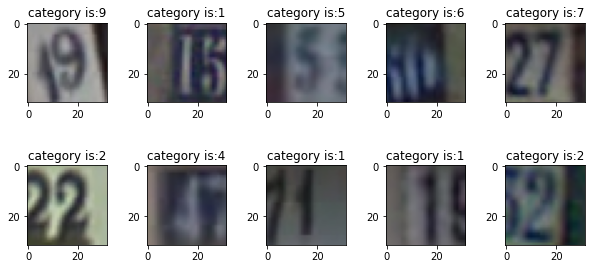

In [6]:
# show colorful images
import random

plt.figure(figsize=(10,5))

for i in range(10):
    n=random.randint(0,train_data.shape[3])
    a=train_data[:,:,:,n]
    plt.subplot(2,5,i+1)
    plt.imshow(a)
    plt.title(f'category is:{train_targets[n,0]}')
    plt.subplots_adjust(hspace=0.1,wspace=0.5)
plt.show()

In [7]:
# combine 3 channels of colorful image: train_data

train_data_grey=np.zeros((train_data.shape[3],train_data.shape[0],train_data.shape[1],1))
for i in range(train_data.shape[3]):
    train_data_grey[i,:,:,0]=(train_data[:,:,0,i]+train_data[:,:,1,i]+train_data[:,:,2,i])/3.0

In [8]:
# test_data

test_data_grey=np.zeros((test_data.shape[3],test_data.shape[0],test_data.shape[1],1))
for i in range(test_data.shape[3]):
    test_data_grey[i,:,:,0]=(test_data[:,:,0,i]+test_data[:,:,1,i]+test_data[:,:,2,i])/3.0

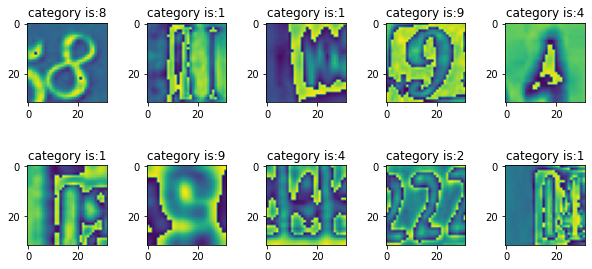

In [9]:
# plot greyscale data

plt.figure(figsize=(10,5))

for i in range(10):
    n=random.randint(0,train_data.shape[3])
    a=train_data_grey[n,:,:,:]
    plt.subplot(2,5,i+1)
    plt.imshow(a)
    plt.title(f'category is:{train_targets[n,0]}')
    plt.subplots_adjust(hspace=0.1,wspace=0.5)
plt.show()

In [10]:
# normalisation
train_data=train_data_grey/(np.max(train_data_grey))
test_data=test_data_grey/(np.max(test_data_grey))

In [11]:
# the 10 in labels is 0
for i in range(train_targets.shape[0]):
    if train_targets[i,0]==10:
        train_targets[i,0]=0

for i in range(test_targets.shape[0]):
    if test_targets[i,0]==10:
        test_targets[i,0]=0        

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [117]:
# checkpoint for auto-save the best weights
def checkpoint(filepath):
    checkpoint=tf.keras.callbacks.ModelCheckpoint(
        filepath=filepath,
        monitor='val_loss',
        save_best_only=True
#         save_weight_only=True
    )
    return checkpoint

In [111]:
# early stop the fitting
def earlystop(patience):
    early_stopping=tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',mode='min',patience=patience)
    return early_stopping
    
    

In [89]:
def get_new_model(input_shape):
    model=tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=input_shape),
        tf.keras.layers.Dense(256,activation='relu'),
        tf.keras.layers.Dense(128,activation='relu'),
        tf.keras.layers.Dense(64,activation='relu'),
        tf.keras.layers.Dense(10,activation='softmax')
    ])
    return model

In [90]:
model=get_new_model(train_data.shape[1:4])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_25 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_26 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_27 (Dense)             (None, 10)                650       
Total params: 304,202
Trainable params: 304,202
Non-trainable params: 0
_________________________________________________________________


In [91]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [112]:
callbacks=[checkpoint('best_results'),earlystop(5)]

In [93]:
history=model.fit(train_data,train_targets[:,0],
        validation_data=(test_data,test_targets[:,0]),
        batch_size=64,epochs=30,
        callbacks=callbacks,
        verbose=2
         )

Train on 73257 samples, validate on 26032 samples
Epoch 1/30
INFO:tensorflow:Assets written to: best_results\assets
73257/73257 - 5s - loss: 2.2248 - accuracy: 0.1902 - val_loss: 2.1481 - val_accuracy: 0.2202
Epoch 2/30
INFO:tensorflow:Assets written to: best_results\assets
73257/73257 - 5s - loss: 2.0691 - accuracy: 0.2596 - val_loss: 2.0006 - val_accuracy: 0.2908
Epoch 3/30
INFO:tensorflow:Assets written to: best_results\assets
73257/73257 - 4s - loss: 1.9266 - accuracy: 0.3294 - val_loss: 1.9240 - val_accuracy: 0.3369
Epoch 4/30
INFO:tensorflow:Assets written to: best_results\assets
73257/73257 - 5s - loss: 1.8551 - accuracy: 0.3617 - val_loss: 1.9014 - val_accuracy: 0.3437
Epoch 5/30
INFO:tensorflow:Assets written to: best_results\assets
73257/73257 - 5s - loss: 1.8193 - accuracy: 0.3813 - val_loss: 1.8807 - val_accuracy: 0.3556
Epoch 6/30
INFO:tensorflow:Assets written to: best_results\assets
73257/73257 - 5s - loss: 1.8053 - accuracy: 0.3864 - val_loss: 1.8745 - val_accuracy: 0.3

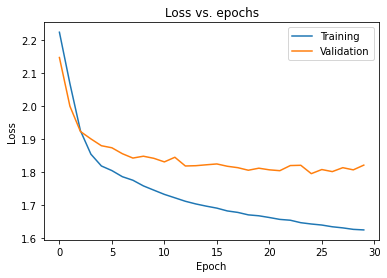

In [94]:
#Run this cell to plot the new loss vs epoch graph

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 


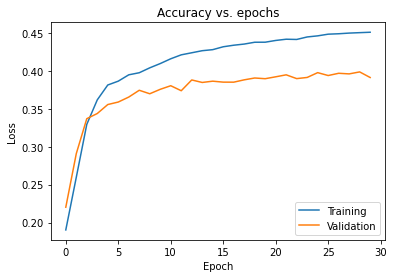

In [95]:
# Run this cell to plot the epoch vs accuracy graph

try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [103]:
def get_cnn_model(input_shape,dropout_rate,weight_decay):
    model=tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=64,kernel_size=3,padding="SAME",activation='relu',
#                                kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
                              input_shape=input_shape,name='conv_1'),
        
        tf.keras.layers.MaxPool2D(pool_size=(2,2),name='pool_1'),
        
        tf.keras.layers.Conv2D(filters=32,kernel_size=3,padding="SAME",activation='relu',
#                                kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
                              name='conv_2'),
        
        tf.keras.layers.MaxPool2D(pool_size=(2,2),name='pool_2'),
        
        tf.keras.layers.Flatten(name='flatten_1'),
        
        tf.keras.layers.Dense(256,activation='relu', name='Dense_1',
                              kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
        
        tf.keras.layers.Dropout(dropout_rate),
        
        tf.keras.layers.Dense(128,activation='relu', name='Dense_2',
                              kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
        
        tf.keras.layers.Dropout(dropout_rate),
        
        tf.keras.layers.Dense(64,activation='relu', name='Dense_3',
                              kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
        
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Dense(10,activation='softmax'),
    ])
    
    return model
    

In [104]:
cnn_model=get_cnn_model(train_data.shape[1:4],0.3,0.001)
cnn_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 32, 32, 64)        640       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 16, 16, 64)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 16, 16, 32)        18464     
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
Dense_1 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)              

In [105]:
cnn_model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [113]:
callbacks=[checkpoint('best_results_cnn'),earlystop(10)]

In [118]:
history_cnn=cnn_model.fit(train_data,train_targets[:,0],
        validation_data=(test_data,test_targets[:,0]),
        batch_size=64,epochs=100,
        callbacks=callbacks,
        verbose=2
         )

Train on 73257 samples, validate on 26032 samples
Epoch 1/100
73257/73257 - 7s - loss: 0.5860 - accuracy: 0.8588 - val_loss: 0.6282 - val_accuracy: 0.8428
Epoch 2/100
73257/73257 - 7s - loss: 0.5879 - accuracy: 0.8579 - val_loss: 0.6087 - val_accuracy: 0.8510
Epoch 3/100
73257/73257 - 7s - loss: 0.5873 - accuracy: 0.8568 - val_loss: 0.6236 - val_accuracy: 0.8459
Epoch 4/100
73257/73257 - 7s - loss: 0.5821 - accuracy: 0.8597 - val_loss: 0.6187 - val_accuracy: 0.8501
Epoch 5/100
73257/73257 - 7s - loss: 0.5815 - accuracy: 0.8585 - val_loss: 0.6029 - val_accuracy: 0.8528
Epoch 6/100
73257/73257 - 7s - loss: 0.5828 - accuracy: 0.8595 - val_loss: 0.6020 - val_accuracy: 0.8532
Epoch 7/100
73257/73257 - 7s - loss: 0.5788 - accuracy: 0.8616 - val_loss: 0.6276 - val_accuracy: 0.8453
Epoch 8/100
73257/73257 - 7s - loss: 0.5835 - accuracy: 0.8579 - val_loss: 0.6334 - val_accuracy: 0.8403
Epoch 9/100
73257/73257 - 7s - loss: 0.5794 - accuracy: 0.8603 - val_loss: 0.6034 - val_accuracy: 0.8529
Epoch

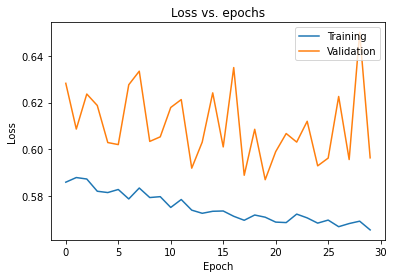

In [119]:
#Run this cell to plot the new loss vs epoch graph

plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 


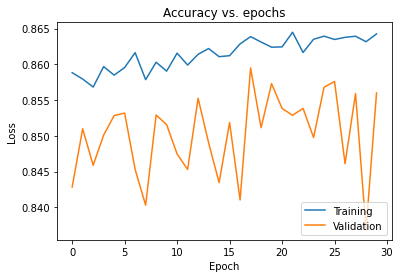

In [120]:
# Run this cell to plot the epoch vs accuracy graph

try:
    plt.plot(history_cnn.history['accuracy'])
    plt.plot(history_cnn.history['val_accuracy'])
except KeyError:
    plt.plot(history_cnn.history['acc'])
    plt.plot(history_cnn.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [12]:
model_val=tf.keras.models.load_model(filepath='best_results_cnn')

In [13]:
# history=model_val.predict(test_data)

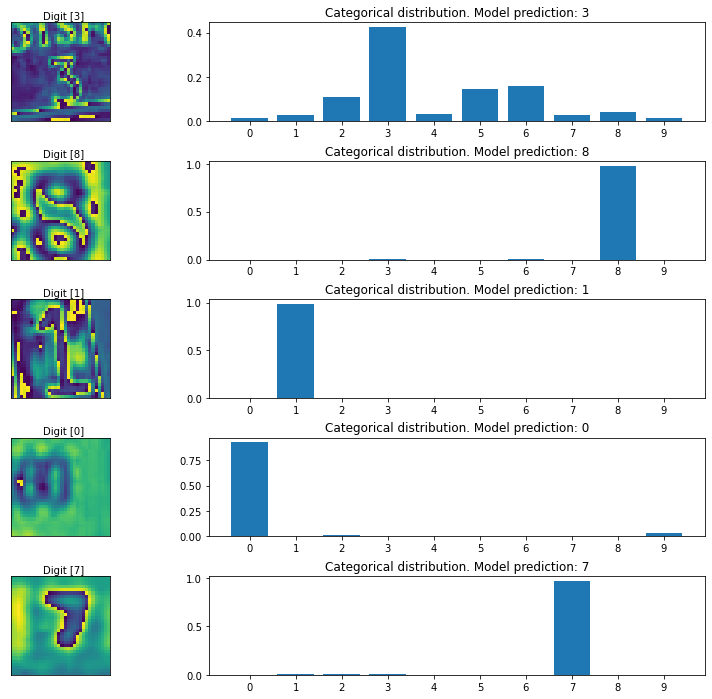

In [19]:
# Run this cell to get model predictions on randomly selected test images

num_test_images = test_data.shape[0]

random_inx = np.random.choice(num_test_images, 5)
random_test_images = test_data[random_inx, ...]
random_test_labels = test_targets[random_inx, ...]

predictions = model_val.predict(random_test_images)

fig, axes = plt.subplots(5, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_title(f"Categorical distribution. Model prediction: {np.argmax(prediction)}")
    
plt.show()